This notebook provides an example to investigate the fisher information before and after training.

In [1]:
import sys
sys.path.append("..")

In [2]:
import torch
from source.utils.utils import load_model
from source.utils.data_funcs import load_data
from source.utils.logger import Logger
from source.utils.connect import interpolate_state_dicts
from source.utils.weight_matching import weight_matching
from source.utils.activation_matching import activation_matching
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

from source.utils.fim import fim_diag

In [3]:
class config:
    model = 'plain_cifar_resnet20'
    dataset = 'cifar10'
    special_init = None # 'vgg_init' (kaiming init) or None (uniform init)
    print_freq = 100
    data_dir = '../../Linear_Mode_Connectivity/data'
    n = 3 # number of interpolation points

In [4]:
# necessary to create logger if using the train/validate/eval_line etc. functions
Logger.setup_logging()
logger = Logger()

trainset, testset = load_data(config.data_dir, config.dataset)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=256, shuffle=False)

trainset_noaug, _ = load_data(config.data_dir, config.dataset, no_random_aug=True)
trainloader_noaug = DataLoader(trainset_noaug, batch_size=128, shuffle=True)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
sd_1 = torch.load(f'../../Linear_Mode_Connectivity/same_init_ex/{config.dataset}/{config.model}/diff_init/seed_10/model_1_160.pt', map_location=device)
sd_2 = torch.load(f'../../Linear_Mode_Connectivity/same_init_ex/{config.dataset}/{config.model}/diff_init/seed_10/model_2_160.pt', map_location=device)

model_1 = load_model(config).to(device)
model_2 = load_model(config).to(device)
model_1.load_state_dict(sd_1)
model_2.load_state_dict(sd_2)

<All keys matched successfully>

In [ ]:
sd_2_wm, _ = weight_matching(config.model, sd_1, sd_2, device=device)
sd_2_am, _ = activation_matching(config.model, model_1, model_2, trainloader, 100, device)

model_2_wm = load_model(config).to(device)
model_2_wm.load_state_dict(sd_2_wm)
model_2_am = load_model(config).to(device)
model_2_am.load_state_dict(sd_2_am)

In [7]:
sd_mid = interpolate_state_dicts(sd_1, sd_2, 0.5)
sd_wm_mid = interpolate_state_dicts(sd_1, sd_2_wm, 0.5)
sd_am_mid = interpolate_state_dicts(sd_1, sd_2_am, 0.5)

model_mid = load_model(config).to(device)
model_wm_mid = load_model(config).to(device)
model_am_mid = load_model(config).to(device)

model_mid.load_state_dict(sd_mid)
model_wm_mid.load_state_dict(sd_wm_mid)
model_am_mid.load_state_dict(sd_am_mid)

<All keys matched successfully>

In [8]:
fim_trace = fim_diag(model_1, trainloader_noaug, samples_no=1000, device=device, verbose=0)
fim_trace_mid = fim_diag(model_mid, trainloader_noaug, samples_no=1000, device=device, verbose=0)
fim_trace_wm_mid = fim_diag(model_wm_mid, trainloader_noaug, samples_no=1000, device=device, verbose=0)
fim_trace_am_mid = fim_diag(model_am_mid, trainloader_noaug, samples_no=1000, device=device, verbose=0)

In [9]:
fi_mean, fi_mid_mean, fi_wm_mid_mean, fi_am_mid_mean = [], [], [], []
fi_std, fi_mid_std, fi_wm_mid_std, fi_am_mid_std = [], [], [], []
fi_max, fi_mid_max, fi_wm_mid_max, fi_am_mid_max = [], [], [], []
fi_min, fi_mid_min, fi_wm_mid_min, fi_am_mid_min = [], [], [], []
for k, v in fim_trace[1000].items():
    fi_mean.append(v.mean().item())
    fi_std.append(v.std().item())
    fi_max.append(v.max().item())
    fi_min.append(v.min().item())
    fi_mid_mean.append(fim_trace_mid[1000][k].mean().item())
    fi_mid_std.append(fim_trace_mid[1000][k].std().item())
    fi_mid_max.append(fim_trace_mid[1000][k].max().item())
    fi_mid_min.append(fim_trace_mid[1000][k].min().item())
    fi_wm_mid_mean.append(fim_trace_wm_mid[1000][k].mean().item())
    fi_wm_mid_std.append(fim_trace_wm_mid[1000][k].std().item())
    fi_wm_mid_max.append(fim_trace_wm_mid[1000][k].max().item())
    fi_wm_mid_min.append(fim_trace_wm_mid[1000][k].min().item())
    fi_am_mid_mean.append(fim_trace_am_mid[1000][k].mean().item())
    fi_am_mid_std.append(fim_trace_am_mid[1000][k].std().item())
    fi_am_mid_max.append(fim_trace_am_mid[1000][k].max().item())
    fi_am_mid_min.append(fim_trace_am_mid[1000][k].min().item())

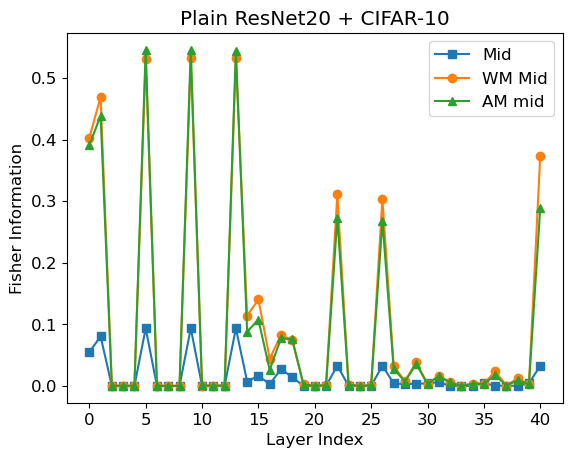

In [10]:
plt.rcParams.update({'font.size': 12})

x_axis = np.arange(len(fi_mean)-1)
plt.plot(x_axis, fi_mid_mean[:-1], label='Mid', marker='s')
plt.plot(x_axis, fi_wm_mid_mean[:-1], label='WM Mid', marker='o')
plt.plot(x_axis, fi_am_mid_mean[:-1], label='AM mid', marker='^')
plt.title('Plain ResNet20 + CIFAR-10')
plt.xlabel('Layer Index')
plt.ylabel('Fisher Information')
plt.legend()
